## RLDMUU 2025
#### UCRL
jakub.tluczek@unine.ch

We continue exploring more advanced approaches to reinforcement learning, this time taking a look at [UCRL](https://papers.nips.cc/paper_files/paper/2006/file/c1b70d965ca504aa751ddb62ad69c63f-Paper.pdf). The main idea is, that when estimating rewards and transition probabilities, we can maintain a set of possible MDPs that fit our problem, by calculating the confidence bounds. Then we optimistically assume that the MDP with the biggest reward is the correct one, and we compute the policy, for example by using value iteration.

In today's task we can use the original bounds for rewards and transitions as presented in paper, that is respectively:

$$ \text{conf}_r (t,s,a) = \min \left\{ 1, \sqrt{\frac{\log(2 t^{\alpha} |S| |A|)}{2 N_t (s,a)}} \right\} $$

$$ \text{conf}_p (t,s,a) = \min \left\{ 1, \sqrt{\frac{\log(4 t^{\alpha} |S|^2 |A|)}{2 N_t (s,a)}} \right\}$$

While the estimates for $\hat{r}_t (s,a)$ and $\hat{p}_t (s, a, s')$, are just:

$$ \hat{r}_t (s,a) = \frac{R_t (s,a)}{N_t (s,a)} $$

$$ \hat{p}_t (s, a, s') = \frac{P_t (s,a,s')}{N_t (s,a)} $$

where $R_t (s,a)$, $P_t(s,a,s')$ and $N_t (s,a)$ are the sums of rewards, transitions to $s'$ from $(s,a)$ and number of times visited, respectively. 

In [51]:
import gymnasium as gym 
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from tqdm import tqdm

In [57]:
class DiscreteMDP:
    def __init__(self, n_states, n_actions, P = None, R = None):
        self.n_states = n_states 
        self.n_actions = n_actions 
        if (P is None):
            self.P = np.zeros([n_states, n_actions, n_states]) 
            for s in range(self.n_states):
                for a in range(self.n_actions):
                    self.P[s,a] = np.random.dirichlet(np.ones(n_states))
        else:
            self.P = P
        if (R is None):
            self.R = np.zeros([n_states, n_actions])
            for s in range(self.n_states):
                for a in range(self.n_actions):
                    self.R[s,a] = np.round(np.random.uniform(), decimals=1)
        else:
            self.R = R
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                assert(abs(np.sum(self.P[s,a,:])-1) <= 1e-3)
                assert((self.P[s,a,:] <= 1).all())
                assert((self.P[s,a,:] >= 0).all())
                
    def get_transition_probability(self, state, action, next_state):
        return self.P[state, action, next_state]
    
    def get_transition_probabilities(self, state, action):
        return self.P[state, action]
    
    def get_reward(self, state, action):
        return self.R[state, action]
    
def value_iteration(mdp: DiscreteMDP, gamma: float, n_iters: int):
    policy = np.zeros(mdp.n_states)
    V = np.zeros(mdp.n_states)
    Q = np.zeros([mdp.n_states, mdp.n_actions])
    for _ in range(n_iters):
        for s in range(mdp.n_states):
            for a in range(mdp.n_actions):
                Q[s,a] = mdp.get_reward(s,a)
                P = mdp.get_transition_probabilities(s,a)
                for next_s in range(mdp.n_states):
                    Q[s,a] += gamma * P[next_s] * V[next_s]
        V = np.max(Q, axis=1)
        policy = np.argmax(Q, axis=1)
    return policy, V

In [83]:
class UCRL:
    def __init__(self, states, actions, alpha):
        self.num_states = states 
        self.num_actions = actions 
        self.alpha = alpha 
        # TODO: initialize R_t, P_t and N_t
        self.t = 0
        self.R = np.zeros((states, actions))
        self.P = np.zeros((states, actions, states))
        self.N = np.ones((states, actions))
        # TODO: initialize a policy
        self.policy = np.zeros(states)

    def act(self,state):
        if np.random.rand() < .1:
            return np.random.choice(self.num_actions)
        else:
            return self.policy[state]

    def get_confidence_bounds(self):
        # TODO: get P and R estimates 
        estimate_reward = self.R / self.N
        estimate_transition = np.zeros((self.num_states, self.num_actions, self.num_states))
        for s in range(self.num_states):
            for a in range(self.num_actions):
                for sp in range(self.num_states):
                    estimate_transition[s,a,sp] = self.P[s,a,sp] / self.N[s,a]

        # TODO: get confidence bounds 
        confidence_reward = np.zeros((self.num_states, self.num_actions))
        confidence_transition = np.zeros((self.num_states, self.num_actions))
        for s in range(self.num_states):
            for a in range(self.num_actions):
                confidence_reward[s,a] = min(1., np.sqrt((np.log(2 * (self.t ** self.alpha) * self.num_states * self.num_actions))/(2 * self.N[s,a])))
                confidence_transition[s,a] = min(1., np.sqrt((np.log(4 * (self.t ** self.alpha) * (self.num_states ** 2) * self.num_actions))/(2 * self.N[s,a])))
        
        return estimate_reward, confidence_reward, estimate_transition, confidence_transition

    def update_policy(self, r_estimate, r_bound, p_estimate, p_bound):
        # TODO: get the most optimistic rewards and transitions within the confidence intervals
        mdp_rewards = r_estimate + r_bound 
        #mdp_transitions = p_estimate + np.repeat(p_bound[:,:,np.newaxis], self.num_states, axis=2)
        mdp_transitions = np.zeros((self.num_states, self.num_actions, self.num_states))
        for s in range(self.num_states):
            for a in range(self.num_actions):
                for sp in range(self.num_states):
                    mdp_transitions[s,a,sp] = p_estimate[s,a,sp] + p_bound[s,a]
        mdp_transitions /= mdp_transitions.sum(axis=2, keepdims=True)
        # TODO: perform value iteration and update greedy policy
        mdp = DiscreteMDP(self.num_states, self.num_actions, mdp_transitions, mdp_rewards)
        self.policy, _ = value_iteration(mdp, gamma=.95, n_iters=20)

    def update_counters(self, state, action, next_state, reward):
        # TODO: Update R_t, P_t and N_t
        self.t += 1
        self.R[state, action] += reward
        self.P[state, action, next_state] += 1
        self.N[state, action] += 1

In [84]:
env = gym.make('FrozenLake-v1', is_slippery=True)

N_EPISODES = 20000
N_ITER = 50

ALPHA = 0.1

state, info = env.reset()
done = False

algo = UCRL(states=env.observation_space.n, actions=env.action_space.n, alpha=ALPHA)

nsteps = np.ones(N_EPISODES) * N_ITER
mean_episode_rewards = np.zeros(N_EPISODES)

for e in tqdm(range(N_EPISODES)):
    r_estimate, r_bound, p_estimate, p_bound = algo.get_confidence_bounds()
    algo.update_policy(r_estimate, r_bound, p_estimate, p_bound)

    for i in range(N_ITER):
        action = algo.act(state)

        next_state, reward, done, truncated, info = env.step(action)

        algo.update_counters(state, action, next_state, reward)

        if done or truncated:
            state, info = env.reset()
            done = False 
            truncated = False
            if reward == 1:
                nsteps[e] = i
                mean_episode_rewards[e] = 1 / i
            break 

        state = next_state

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_1879/4294611417.py:34: RuntimeWarning: divide by zero encountered in log
  confidence_reward[s,a] = min(1., np.sqrt((np.log(2 * (self.t ** self.alpha) * self.num_states * self.num_actions))/(2 * self.N[s,a])))
/tmp/ipykernel_1879/4294611417.py:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_reward[s,a] = min(1., np.sqrt((np.log(2 * (self.t ** self.alpha) * self.num_states * self.num_actions))/(2 * self.N[s,a])))
/tmp/ipykernel_1879/4294611417.py:35: RuntimeWarning: divide by zero encountered in log
  confidence_transition[s,a] = min(1., np.sqrt((np.log(4 * (self.t ** self.alpha) * (self.num_states ** 2) * self.num_actions))/(2 * self.N[s,a])))
/tmp/ipykernel_1879/4294611417.py:35: RuntimeWarning: invalid value encountered in sqrt
  confidence_transition[s,a] = min(1., np.sqrt((np.log(4 * (self.t ** self.alpha) * (self.num_states ** 2) * self.num_actions))/(2 * self.N[s,a])))
100%|██████████| 20000/20000 [04:56<0

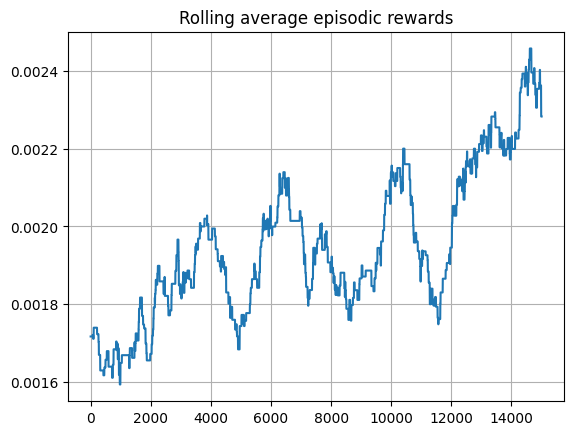

In [87]:
from matplotlib import pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(mean_episode_rewards, 5000))
plt.title("Rolling average episodic rewards")
plt.grid()

In [88]:
algo.policy

array([1, 2, 0, 2, 1, 0, 1, 0, 1, 2, 2, 0, 0, 1, 3, 0])